# Programming Probabilistically

***
## Programming Probabilistically

***
## Probabilistic Programming

***
## PyMC3 Primer

In [1]:
# import libs
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Coin Flip
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [3]:
# Specify our first model wtih beta prior & bernoulli likelihood
with pm.Model() as our_first_model: # Create container for model
    θ = pm.Beta('θ', alpha=1., beta=1.) # specify prior - using \beta as the name in here is best practice
                                        # \beta is a probability dist for which we can produce rand nums & probability densities
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123) # The inference button

C:\Users\wallj\AppData\Local\Temp/ipykernel_7368/1523647649.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, random_seed=123) # The inference button
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


***
## Summarizing the Posterior

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

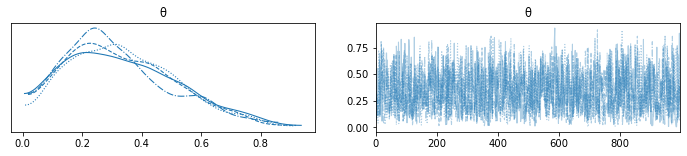

In [4]:
# Left: KDE Kernel Density Estimation - smoothed histogram
# Right: Individual sampled values at each step 
az.plot_trace(trace)

In [5]:
# Mean, Standard Deviation, 94% HPD
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.332,0.18,0.016,0.65,0.005,0.003,1418.0,1928.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'θ'}>

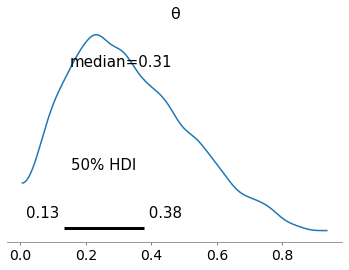

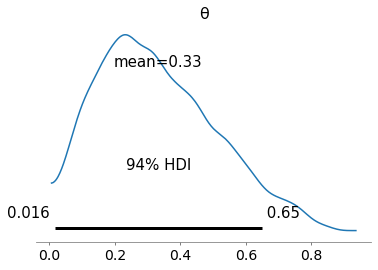

In [6]:
# Black line is 94% HPD - change using credible interval setting
az.plot_posterior(trace,point_estimate='median',hdi_prob=0.50)
az.plot_posterior(trace,point_estimate='auto',hdi_prob=0.94) # default

To make decisions, we can see 0.5 is in our HPD so the coin could be fair, but the mean is way closer to tails based, how can we get more data and sharpen our model?

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'θ'}>

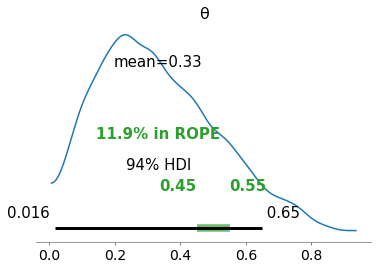

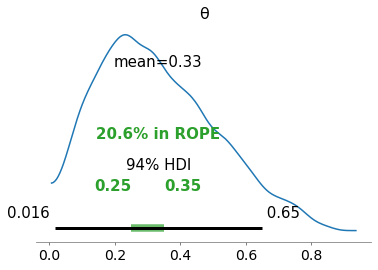

In [7]:
# Rope - Region of practical equivalence - a range set by practitioner - relatively subjective
az.plot_posterior(trace, rope=[0.45, .55])
az.plot_posterior(trace, rope=[0.25,0.35])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'θ'}>

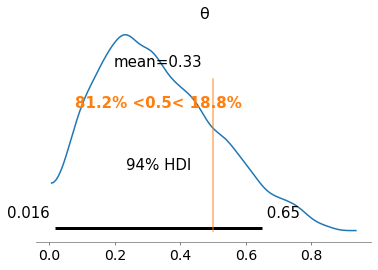

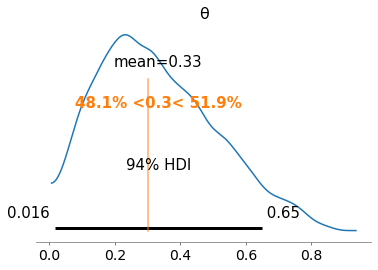

In [8]:
# Rope Reference Value - another practitioner chosen value with proportions over & under
az.plot_posterior(trace, ref_val=0.5) 
az.plot_posterior(trace, ref_val=0.3) 

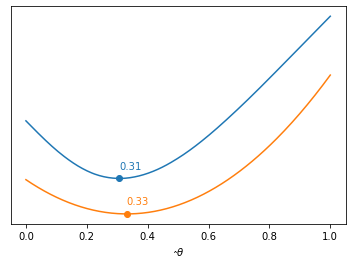

In [9]:
# Loss Functions - diff between true value & estimated value (true value represented here by distribution)
# lossf_a = absolute loss
# lossf_b = quadratic loss
# Different loss functions = different relate to different point estimates (absolute = median, quadratic = mean)
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

Text(0.5, 0, '$\\hat \\theta$')

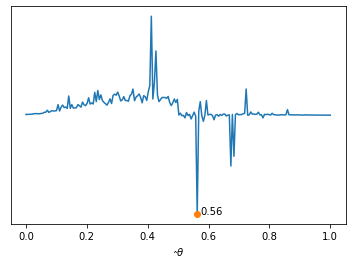

In [10]:
# Sometimes loss functions aren't as simple as point estimates - a decision that has more cost than benefit
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

***
## Gaussians all the way down

([<matplotlib.axis.YTick at 0x28b74222e50>], [Text(0, 0, '')])

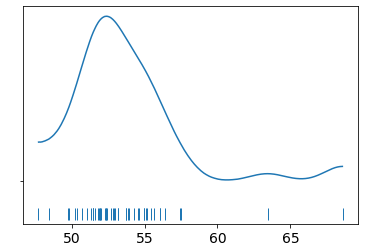

In [11]:
# Data doesn't matter here - just think of a normal distribution - heights or something (notice the two outliers)
data = np.loadtxt('C:\\Users\\wallj\\DS_Projects\\Bayesian_Inference\\Bayesian_Analysis_Python\\BAP\\code\\data\\chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

C:\Users\wallj\AppData\Local\Temp/ipykernel_7368/2784694328.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

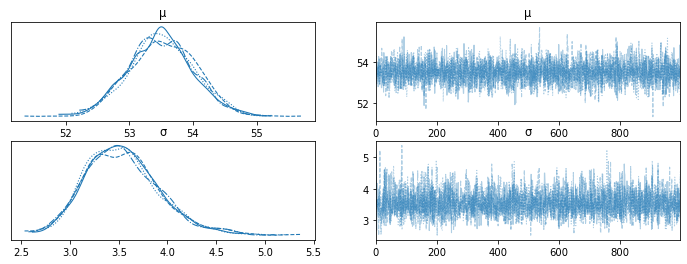

In [12]:
# μ is a uniform dist with lower & upper bounds - prior of what we think we're bound between
# σ is a half normal dist (normal w/abs vls) with sd of 10 - prior - just a large sd
# y is a normal distr for our data
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

C:\Users\wallj\anaconda3\lib\site-packages\arviz\plots\jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

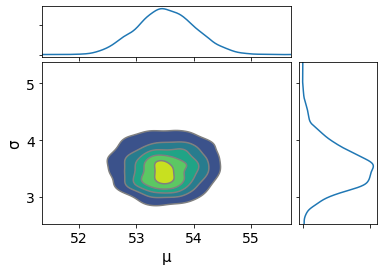

In [13]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [14]:
az.summary(trace_g)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.508,0.514,52.561,54.483,0.009,0.006,3562.0,2801.0,1.0
σ,3.538,0.379,2.845,4.225,0.006,0.004,3591.0,2866.0,1.0


In [15]:
# Sample from the posterior to make predictions
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

C:\Users\wallj\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


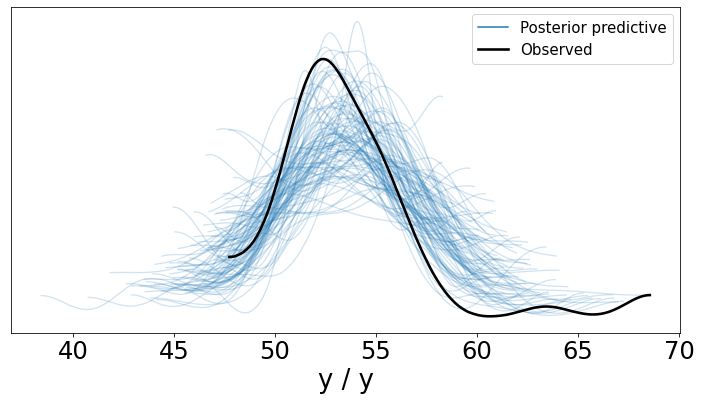

In [16]:
# the mean is slightly displaced because of the outliers
# We can remove teh outliers using 1.5 the interquartile range or 2 the sd
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)

In [17]:
# Or change the model based on this data - students t is popular for this
np.mean(stats.t(loc=0, scale=1, df=1).rvs(100))

-1.2692628964725186

In [18]:
# Try wtih larger value
np.mean(stats.t(loc=0, scale=1, df=10).rvs(100))

0.08885391792102

(-5.0, 5.0)

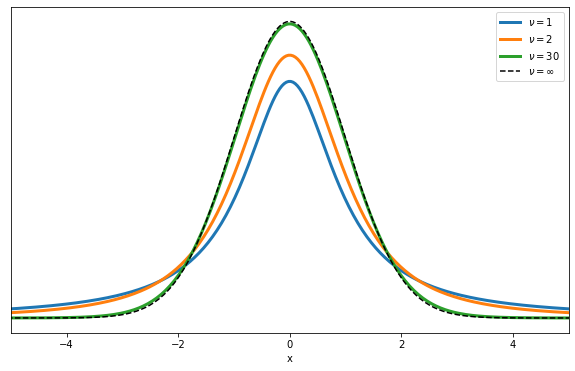

In [19]:
# Scale
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

C:\Users\wallj\AppData\Local\Temp/ipykernel_7368/3222312457.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

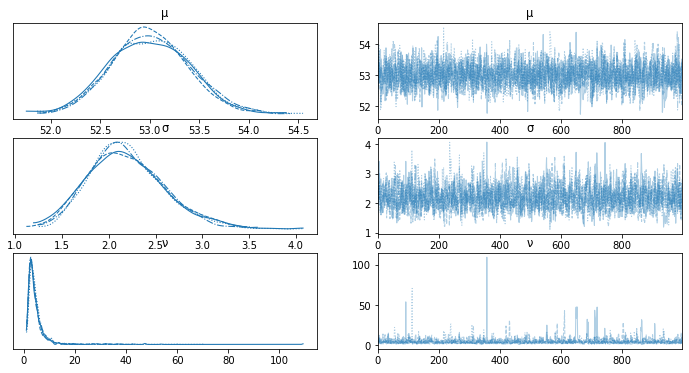

In [20]:
# Last problem except use an exponential prior into a students t dist
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

In [21]:
az.summary(trace_t)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.008,0.395,52.290,53.747,0.008,0.006,2320.0,2258.0,1.0
σ,2.192,0.411,1.460,2.983,0.010,0.007,1625.0,1477.0,1.0
ν,4.623,4.306,1.134,9.522,0.117,0.083,1757.0,1846.0,1.0


C:\Users\wallj\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wallj\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

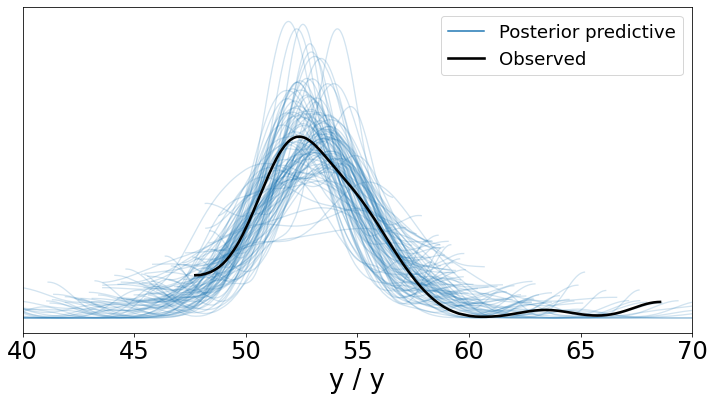

In [22]:
# Posterior check - looks much better - not being sucked in by outliers
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)
plt.xlim(40, 70)

***
## Groups Comparison

***
## Summary

***
## Exercises

***
***
***